# Интерактивная карта фрактального множества (2024-2025)

### Условие задачи

**Дано:**

Варианты фрактальных множеств:

- [фрактал Ляпунова](https://ru.wikipedia.org/wiki/Фрактал_Ляпунова)
  1. ABAB
  2. BBBBBAAAAA
  3. AABABAA
  4. ABBABBA

- [множество Жюлиа](https://ru.wikipedia.org/wiki/Множество_Жюлиа)
  5. $z_{n+1} = z^3_n + z_n + c$
  6. $z_{n+1} = z^4_n + z^2_n + c$
  7. $z_{n+1} = z^3_n + z^2_n + c$
  8. $z_{n+1} = z^4_n + z_n + c$

- [бассейны Ньютона](https://ru.wikipedia.org/wiki/Бассейны_Ньютона)
  9. $p(z) = z^3 - 1$
  10. $p(z) = z^8 + 15z^4 - 16$
  11. $p(z) = z^3 - 2z + 2$
  12. $p(z) = sin(z) \cdot cos(z)$


Обозначим за $\lambda$:
 - количество итераций (множество Жюлиа),
 - количество итераций для достижения заданной погрешности достижения корня (бассейны Ньютона)
 - экспонента Ляпунова (фрактал Ляпунова)

**Требуется**

 - реализовать функции и откомпилировать их при помощи модуля `Numba`:
     - расчет $\lambda$ для точки на комплексной плоскости
     - расчет $\lambda$ на регулярной решетке на комплексной плоскости (эта функция должна быть распараллелена при помощи `Numba.prange`)

 - создать интерактивную карту при помощи класса `DynamicMap` модуля `holoviews`:
     - цветом отобразить значение $\lambda$
     - выбрать цветовую карту [colormap](https://matplotlib.org/stable/tutorials/colors/colormaps.html)
     - размеры карты - не менее 600 х 600 точек
     - отрегулировать количество итераций так, чтобы время вычисления одного обновления карты было менее 1 секунды

 - сохранить 3 различных изображения:
     - найти красивые места на карте, применив переносы и масштабирования
     - воспользоваться кнопкой сохранения на интерактивной карте

 - добавить описание:
     - к каждой константе (комментарий)
     - к каждой функции (`docstring`)

**Замечания**

1. Интерактивная карта на основе `Holoviews` работает в `Jupyter Lab` (см. материалы к первому модулю).

Установить `Jupyter Lab` (а также `Jupyter Notebook` и всё, что для этих модулей нужно):
> pip install jupyter

Запустить `Jupyter Lab`:
> jupyter lab

**Правила оценивания:**

- оценка за корректно реализованные функции и созданную интерактивную карту `100` баллов

- штрафы $p(i)$, баллов:
    - не работает интерактивная карта - 50
    - ошибки в реализации функций - 20
    - не выполнена компиляция и распараллеливание - 20
    - отсутствует 3 изображения - 20
    - отсутствует `docstring` - 20
    - менее значимые недоработки - 10
    - другие ошибки штрафуются индивидуально в зависимости от их тяжести

- итоговая оценка за задание = $100 - \sum_{i}{p(i)}$

In [39]:
!pip install jupyter_bokeh

In [41]:
import numpy as np
import numba as nb
from numba import jit, njit, prange
import time
import matplotlib.pyplot as plt
import holoviews as hv
from holoviews import opts
from holoviews.streams import RangeXY
from ipywidgets import interact, FloatRangeSlider

In [43]:
# Используем массив из 0, 1 вместо A, B
sequence = 'ABBABBA'
new_seq = np.array([1 if char == 'B' else 0 for char in sequence])

In [45]:
@njit()
def calculate_exponent(sequence, alpha, beta, iterations=500):
    """
    Рассчитывает значение для конкретной точки.

    Аргументы:
        sequence (ndarray): Последовательность параметров
        alpha (float): Параметр alpha для вычислений
        beta (float): Параметр beta для вычислений
        iterations (int): Количество шагов для расчёта

    Возвращаемое значение:
        float: Среднее значение экспоненты
    """
    x_start = 0.5
    log_sum = 0.0
    eps = 1e-7

    parameters = np.array([alpha if sequence[i % len(sequence)] == 0 else beta for i in range(iterations)])

    for k in range(iterations):
        current_param = parameters[k]
        log_sum += np.log(abs(current_param * (1 - 2 * x_start)) + eps)
        x_start = current_param * x_start * (1 - x_start)

    return log_sum / iterations


In [47]:
@njit(parallel=True)
def create_fractal_map(sequence, a_range, b_range, steps=500):
    """
    Строит карту фрактала на основе входной последовательности

    Аргументы:
        sequence (ndarray): Массив последовательности параметров
        a_range (ndarray): Диапазон значений alpha
        b_range (ndarray): Диапазон значений beta
        steps (int): Количество шагов для расчёта.

    Возвращаемое значение:
        ndarray: Двумерный массив с рассчитанными значениями.
    """
    fractal_grid = np.zeros((len(a_range), len(b_range)))
    eps = 1e-7

    for i in prange(len(a_range)):
        for j in range(len(b_range)):
            y_value = 0.5
            log_accum = 0.0

            for iteration in range(steps):
                current_value = a_range[i] if sequence[iteration % len(sequence)] == 0 else b_range[j]
                log_accum += np.log(abs(current_value * (1 - 2 * y_value)) + eps)
                y_value = current_value * y_value * (1 - y_value)

            fractal_grid[i, j] = log_accum / steps

    return fractal_grid

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
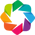

:DynamicMap   []
   :Image   [x,y]   (z)

In [49]:
canvas_width, canvas_height = 700, 700  # Размеры изображения
iteration_steps = 200  # Количество итераций для расчёта

def compute_fractal(value_range_x, value_range_y):
    """
    Рассчитывает значения фрактала для заданных диапазонов.

    Аргументы:
        value_range_x (tuple): Кортеж из двух чисел, задающий минимальное и максимальное значения параметра x.
        value_range_y (tuple): Кортеж из двух чисел, задающий минимальное и максимальное значения параметра y.

    Возвращаемое значение:
        hv.Image: Объект HoloViews с рассчитанными значениями фрактала, отображаемый как изображение.
    """
    x_min, x_max = value_range_x
    y_min, y_max = value_range_y
    x_axis_values = np.linspace(x_min, x_max, canvas_width)
    y_axis_values = np.linspace(y_min, y_max, canvas_height)

    fractal_matrix = create_fractal_map(new_seq, x_axis_values, y_axis_values, iteration_steps)
    return hv.Image(fractal_matrix.T, bounds=(x_min, y_min, x_max, y_max))

hv.extension('bokeh')

def update_fractal_plot(x_range=None, y_range=None):
    """
    Обновляет изображение фрактала для новых диапазонов.

    Аргументы:
        x_range (tuple, optional): Кортеж из двух чисел, задающий диапазон значений параметра x.
                                   Если не задано, используется значение по умолчанию (0, 4).
        y_range (tuple, optional): Кортеж из двух чисел, задающий диапазон значений параметра y.
                                   Если не задано, используется значение по умолчанию (0, 4).

    Возвращаемое значение:
        hv.Image: Объект HoloViews с обновленным изображением фрактала.
    """
    if x_range is None or y_range is None:
        x_range = (0, 4)
        y_range = (0, 4)
    fractal_image = compute_fractal(x_range, y_range)
    return fractal_image.opts(
        opts.Image(cmap='plasma', colorbar=True, width=600, height=600, title="Lyapunov Fractal")
    )

stream_ranges = RangeXY(x_range=(0, 4), y_range=(0, 4))

interactive_map = hv.DynamicMap(update_fractal_plot, streams=[stream_ranges])
interactive_map

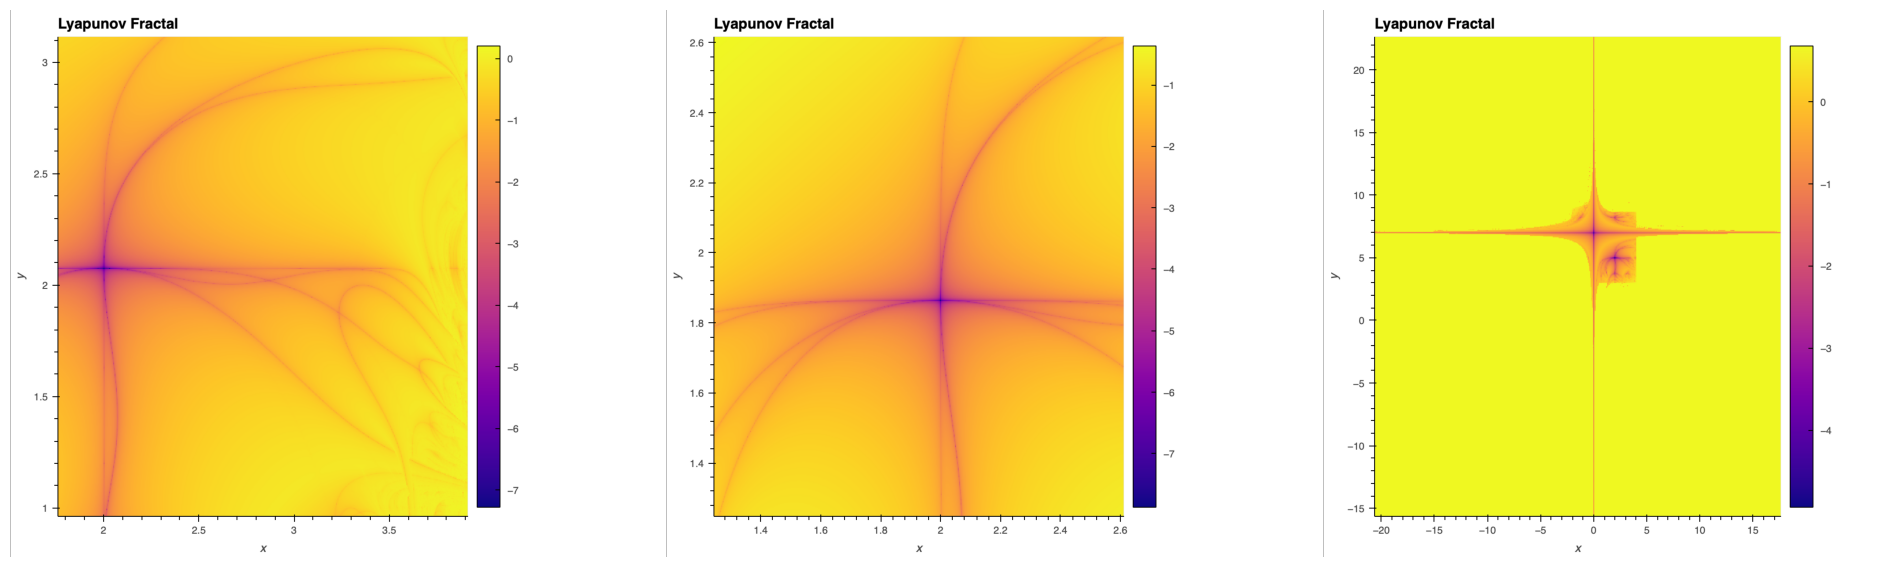

In [51]:
files = ['11.png', '12.png', '13.png']
figure, subplots = plt.subplots(1, len(files), figsize=(24, 10))
for subplot, file in zip(subplots, files):
    image_data = plt.imread(file)
    subplot.imshow(image_data)
    subplot.axis('off')
plt.show()